In [16]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [17]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [18]:
with open('../output/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [19]:
df['NonCriminal'] = df['Criminality'] == 'NC'

# Airport report

For a given airport IATA code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [20]:
airport = 'KBFI'
airport_name = airport_dict[airport]

In [21]:
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

In [22]:
pickup_df = df[pickup]
dropoff_df = df[dropoff]

In [23]:
pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

In [24]:
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
print(f'{unique_pickups} pickups, {unique_dropoffs} dropoffs.')

34443 pickups, 15191 dropoffs.


In [25]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_flights = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_flights = dropoff_df['MissionID'].resample('AS-OCT').nunique()

# Annual trends (by fiscal year)

In [26]:
annual_pickups['2010':'2018']

MissionDate
2010-10-01    6629
2011-10-01    5664
2012-10-01    4797
2013-10-01    3955
2014-10-01    2732
2015-10-01    3129
2016-10-01    3390
2017-10-01    3495
2018-10-01     652
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [27]:
annual_dropoffs['2010':'2018']

MissionDate
2010-10-01     552
2011-10-01    1175
2012-10-01    2153
2013-10-01    2247
2014-10-01    1926
2015-10-01    2737
2016-10-01    1487
2017-10-01    2504
2018-10-01     410
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [28]:
annual_dropoff_flights

MissionDate
2010-10-01    47
2011-10-01    51
2012-10-01    44
2013-10-01    48
2014-10-01    37
2015-10-01    44
2016-10-01    42
2017-10-01    50
2018-10-01     8
Freq: AS-OCT, Name: MissionID, dtype: int64

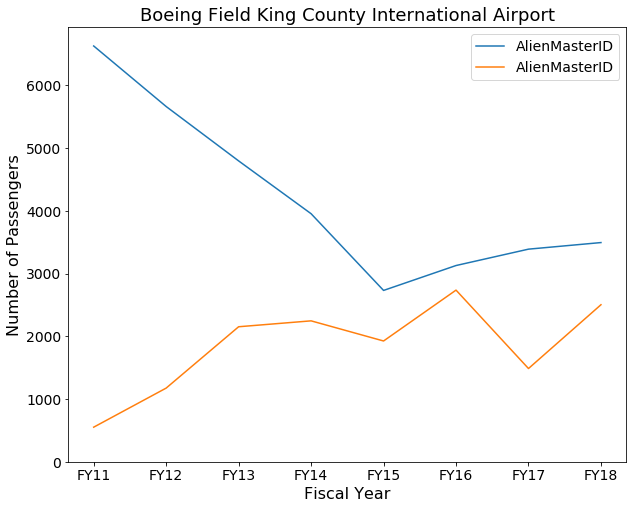

In [29]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    annual_pickups.rename('Total Pickups', inplace=True)
    annual_dropoffs.rename('Total Dropoffs', inplace=True)
    
    fig.set_size_inches(10, 8)
    fig.savefig('../output/ICEFlights.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_pickups['2010':'2017'], annual_dropoffs['2010':'2017']]);

# Annual pickup rate, by criminal conviction status

In [30]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [31]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

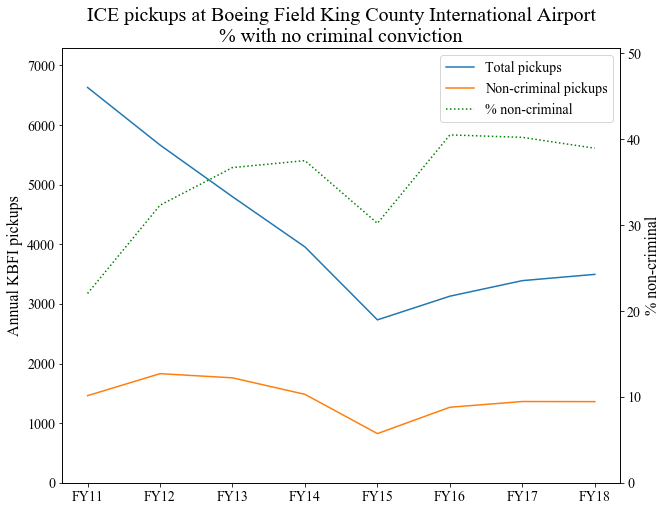

In [32]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

In [33]:
monthly_mean_pickups = pd.DataFrame(columns=['calendar_year', 'monthly_mean_pickups'])
for year in range(2011, 2019):
    mean = monthly_pickups[f'{year}'].mean()
    monthly_mean_pickups = monthly_mean_pickups.append({'calendar_year':year, 'monthly_mean_pickups':mean}, ignore_index=True)
monthly_mean_pickups['calendar_year'] = monthly_mean_pickups['calendar_year'].astype(int)
monthly_mean_pickups = monthly_mean_pickups.set_index('calendar_year')

In [34]:
monthly_mean_pickups

,monthly_mean_pickups
calendar_year,
2011,544.166667
2012,450.166667
2013,383.583333
2014,300.000000
2015,237.666667
2016,264.833333
2017,288.500000
2018,273.166667


In [170]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [171]:
country_of_citizenship_by_year.head()

,PULOC,FY,R-T,CountryOfCitizenship,AlienMasterID,MissionID
0,KBFI,2010-10-01,R,CHINA,6,1
1,KBFI,2010-10-01,R,MEXICO,5809,98
2,KBFI,2010-10-01,T,ARGENTINA,1,1
3,KBFI,2010-10-01,T,BULGARIA,1,1
4,KBFI,2010-10-01,T,CAMBODIA,2,2


In [172]:
pivot = pd.pivot_table(data=country_of_citizenship_by_year,
                       index='FY',
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [173]:
pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)

In [174]:
pivot

CountryOfCitizenship,MEXICO,GUATEMALA,EL SALVADOR,HONDURAS,HAITI,ECUADOR,NICARAGUA,CAMBODIA,COLOMBIA,DOMINICAN REPUBLIC,...,SRI LANKA,TAIWAN,BELIZE,COSTA RICA,IRAN,LEBANON,CONGO,QATAR,BURKINA FASO,NEPAL
FY,,,,,,,,,,,,,,,,,,,,,
2010-10-01,5818,381,183,178,0,28,13,2,6,3,...,0,1,0,0,0,0,0,0,0,0
2011-10-01,4540,635,216,225,0,14,12,0,3,7,...,0,0,0,0,0,0,0,1,0,0
2012-10-01,3368,478,476,428,0,11,16,1,4,0,...,0,0,0,0,0,0,0,0,0,0
2013-10-01,2683,325,656,213,0,18,14,23,6,3,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,1875,278,307,194,0,24,23,5,5,7,...,0,0,1,0,0,0,0,0,0,0
2015-10-01,1654,549,406,275,1,38,14,57,1,8,...,1,0,0,1,1,1,1,0,1,0
2016-10-01,2189,273,209,211,421,22,11,2,16,2,...,0,0,0,0,0,0,0,0,0,0
2017-10-01,2551,377,168,236,37,14,10,19,8,3,...,0,0,0,0,0,0,0,0,0,1
2018-10-01,455,70,39,63,0,2,3,0,2,2,...,0,0,0,0,0,0,0,0,0,0


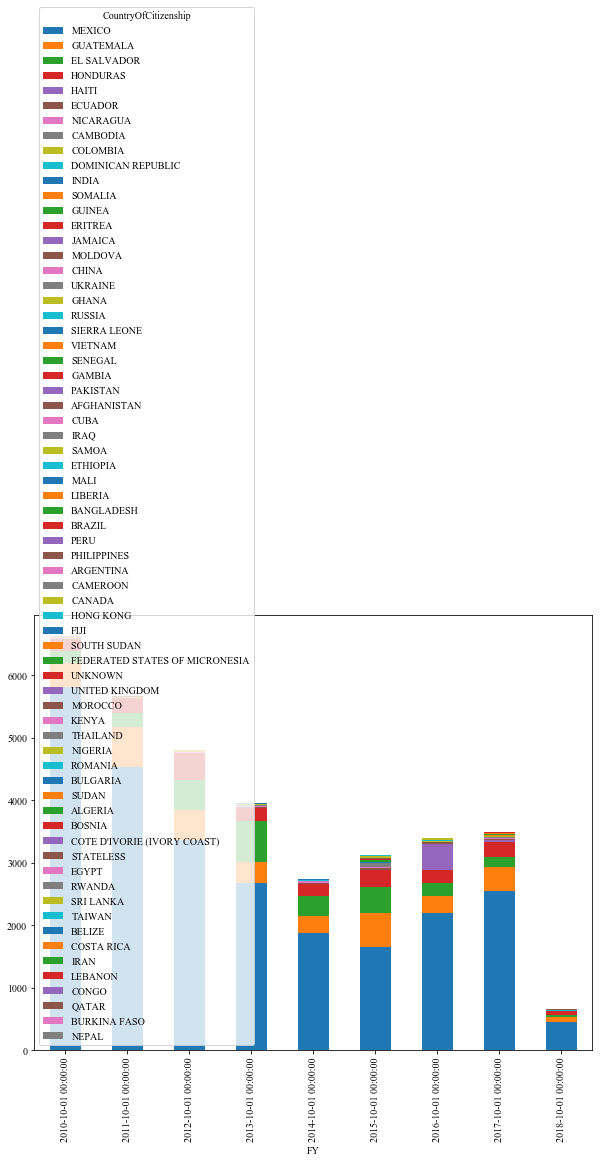

In [175]:
fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8))

In [176]:
country_of_citizenship_by_year.set_index('FY', inplace=True)

In [177]:
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

In [197]:
temp = country_of_citizenship_by_year['2011'][['CountryOfCitizenship', 'AlienMasterID']].head(5)

In [198]:
temp

,CountryOfCitizenship,AlienMasterID
FY,,
2011-10-01,MEXICO,4524
2011-10-01,GUATEMALA,521
2011-10-01,HONDURAS,225
2011-10-01,EL SALVADOR,216
2011-10-01,GUATEMALA,114


In [182]:
temp2 = country_of_citizenship_by_year['2010'][5:]

In [192]:
sum(temp2['AlienMasterID'])

50

## To Do:

Filter `country_of_citizenship_by_year` for removals only

1. Create empty df
2. For each fiscal year:
3. Get temporary df of top 5 nationalities
4. Sum remaining nationalities as "OTHER", add new row to temporary df
5. Append temp df for each fiscal year to empty df in 1
6. Plot?

In [ ]:
# temp = X.SOME_IDENTIFIER.value_counts()
# temp2 = temp.head(10)
# if len(temp) > 10:
#     temp2['remaining {0} items'.format(len(temp) - 10)] = sum(temp[10:])
# temp2.plot(kind='pie')

In [112]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

In [113]:
drop_locs_by_year

,PULOC,FY,R-T,air2_AirportName,AlienMasterID,MissionID
0,KBFI,2010-10-01,R,Phoenix-Mesa-Gateway Airport,51,1
1,KBFI,2010-10-01,R,San Diego International Airport,3827,49
2,KBFI,2010-10-01,R,Valley International Airport,1931,48
3,KBFI,2010-10-01,R,Beijing Capital International Airport,6,1
4,KBFI,2010-10-01,T,El Paso International Airport,2,2
5,KBFI,2010-10-01,T,George Bush Intercontinental Houston Airport,21,1
6,KBFI,2010-10-01,T,Phoenix-Mesa-Gateway Airport,747,61
7,KBFI,2010-10-01,T,San Diego International Airport,43,7
8,KBFI,2010-10-01,T,Valley International Airport,1,1
9,KBFI,2011-10-01,R,La Aurora Airport,114,1
